In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from celluloid import Camera
import torch
import sys
import os
notebook_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(notebook_dir, ".."))
sys.path.append(project_root)
from simulations.n_body_trajectory import n_body_simulation

In [2]:
def convert_to_plot_format(trajectory_data):
    """
    Convert simulation output to format expected by plot_simulation().
    Returns: data list and times array.
    """
    positions = trajectory_data["positions"]          # shape: (T, N, dim)
    masses = trajectory_data["masses"]                # shape: (N,)
    times = trajectory_data["time"].numpy()           # shape: (T,)

    # Expand masses over time so it's (T, N, 1)
    masses_expanded = masses[None, :, None].expand(positions.shape[0], -1, 1)

    # Concatenate along last dimension to get (T, N, dim + 1)
    data_run = torch.cat([positions, masses_expanded], dim=-1).numpy()

    # Wrap in a list to support multiple runs
    return [data_run], times

In [3]:
# def make_transparent_color(length, offset=0.0):
#     """Simple RGBA gradient from opaque to transparent"""
#     return [(0, 0, 1, alpha) for alpha in np.linspace(1, 0, length)]  # Blue, adjustable if you want

def make_transparent_color(ntimes, fraction):
  rgba = np.ones((ntimes, 4))
  alpha = np.linspace(0, 1, ntimes)[:, np.newaxis]
  color = np.array(mpl.colors.to_rgba(mpl.cm.gist_ncar(fraction)))[np.newaxis, :]
  rgba[:, :] = 1*(1-alpha) + color*alpha
  rgba[:, 3] = alpha[:, 0]
  return rgba

def plot_simulation(data, times, sim_type='r2', i=0, animate=False, plot_size=True, s_size=1):
    """
    Plots simulation data.
    
    :data: list of simulation runs, each of shape (nt, n, d+1) -- the last dimension includes mass
    :times: array of shape (nt,)
    :sim_type: 'r2', 'string', etc.
    :i: index of the run to plot
    :animate: whether to animate
    """
    x_times = np.array(data[i])  # shape (nt, n, d+1)
    n = x_times.shape[1]
    masses = x_times[:, :, -1]

    if not animate:
        if sim_type in ['string', 'string_ball']:
            rgba = make_transparent_color(len(times), 0)
            for i in range(0, len(times), len(times)//10):
                ctimes = x_times[i]
                plt.plot(ctimes[:, 0], ctimes[:, 1], color=rgba[i])
            plt.xlim(-5, 20)
            plt.ylim(-20, 5)
        else:
            for j in range(n):
                rgba = make_transparent_color(len(times), j/n)
                if plot_size:
                    plt.scatter(x_times[:, j, 0], x_times[:, j, 1], color=rgba, s=3*masses[:, j]*s_size)
                else:
                    plt.scatter(x_times[:, j, 0], x_times[:, j, 1], color=rgba, s=s_size)
        plt.xlabel("x")
        plt.ylabel("y")
        plt.title(f"Simulation {i}")
        plt.show()
    else:
        if sim_type in ['string', 'string_ball']:
            raise NotImplementedError("Animation for string types not supported.")
        fig = plt.figure()
        camera = Camera(fig)
        d_idx = 20
        for t_idx in range(d_idx, len(times), d_idx):
            start = max([0, t_idx-300])
            cx_times = x_times[start:t_idx]
            for j in range(n):
                rgba = make_transparent_color(len(cx_times), j/n)
                if plot_size:
                    plt.scatter(cx_times[:, j, 0], cx_times[:, j, 1], color=rgba, s=3*masses[start:t_idx, j]*s_size)
                else:
                    plt.scatter(cx_times[:, j, 0], cx_times[:, j, 1], color=rgba, s=s_size)
            camera.snap()
        from IPython.display import HTML
        return HTML(camera.animate().to_jshtml())


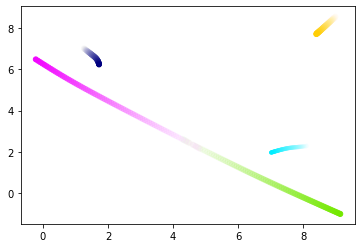

In [8]:
trajectory_data = n_body_simulation()
data, times = convert_to_plot_format(trajectory_data)
plot_simulation(data, times, sim_type='r2', animate=True) 